**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/hybrid-models).**

---


# Introduction #

Run this cell to set everything up!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex5 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor


comp_dir = Path('../input/store-sales-time-series-forecasting')
data_dir = Path("../input/ts-course-data")

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-------------------------------------------------------------------------------

In the next two questions, you'll create a boosted hybrid for the *Store Sales* dataset by implementing a new Python class. Run this cell to create the initial class definition. You'll add `fit` and `predict` methods to give it a scikit-learn like interface.


In [2]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method


# 1) Define fit method for boosted hybrid

Complete the `fit` definition for the `BoostedHybrid` class. Refer back to steps 1 and 2 from the **Hybrid Forecasting with Residuals** section in the tutorial if you need.

In [3]:
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit


# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [4]:
# Lines below will give you a hint or solution code
q_1.hint()
q_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Your solution should look like:
```python
def fit(self, X_1, X_2, y):
    # Fit self.model_1
    self.model_1.fit(X_1, y)

    # Make predictions with self.model_1
    y_fit = pd.DataFrame(
        self.model_1.____(____), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - ____
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(____, ____)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit
```


<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

```

-------------------------------------------------------------------------------

# 2) Define predict method for boosted hybrid

Now define the `predict` method for the `BoostedHybrid` class. Refer back to step 3 from the **Hybrid Forecasting with Residuals** section in the tutorial if you need.

In [5]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict


# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [6]:
# Lines below will give you a hint or solution code
q_2.hint()
q_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Your solution should look like:
```python
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.____(____), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.____(____)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict
```


<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

```

-------------------------------------------------------------------------------

Now you're ready to use your new `BoostedHybrid` class to create a model for the *Store Sales* data. Run the next cell to set up the data for training.

In [7]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

# 3) Train boosted hybrid

Create the hybrid model by initializing a `BoostedHybrid` class with `LinearRegression()` and `XGBRegressor()` instances.

In [8]:
# YOUR CODE HERE: Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)


# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [9]:
# Lines below will give you a hint or solution code
q_3.hint()
q_3.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Your solution should look like:
```python
# Create model
model = BoostedHybrid(
    model_1=____,
    model_2=____,
)
model.fit(X_1, X_2, ____)

y_pred = model.predict(____, ____)
y_pred = y_pred.clip(0.0)
```


<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

```

-------------------------------------------------------------------------------

Depending on your problem, you might want to use other hybrid combinations than the linear regression + XGBoost hybrid you've created in the previous questions. Run the next cell to try other algorithms from scikit-learn.

In [10]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

These are just some suggestions. You might discover other algorithms you like in the scikit-learn [User Guide](https://scikit-learn.org/stable/supervised_learning.html).

Use the code in this cell to see the predictions your hybrid makes.

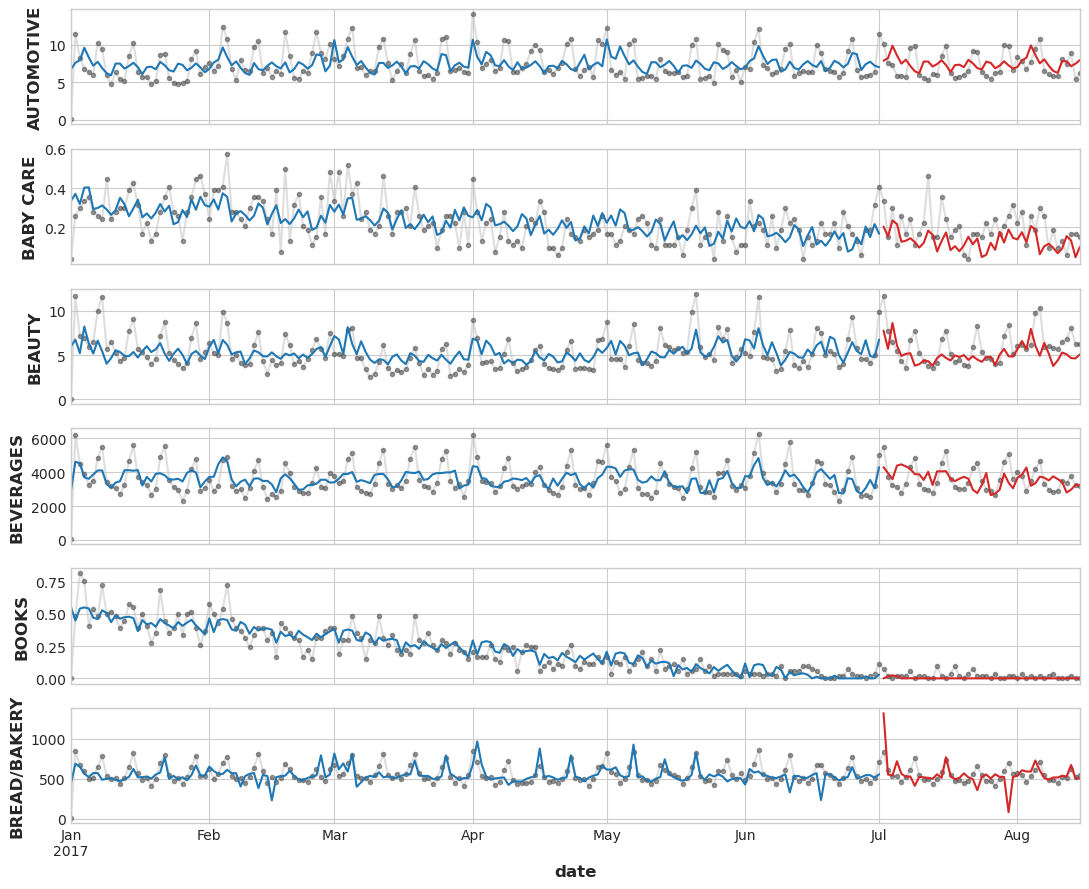

In [11]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

# 4) Fit with different learning algorithms

Once you're ready to move on, run the next cell for credit on this question.

In [12]:
# View the solution (Run this cell to receive credit!)
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 



# Keep Going #

[**Convert any forecasting task**](https://www.kaggle.com/ryanholbrook/forecasting-with-machine-learning) to a machine learning problem with four ML forecasting strategies.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*